# LightGlue Demo
In this notebook we match two pairs of images using LightGlue with early stopping and point pruning.

In [1]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path

# if Path.cwd().name != "LightGlue":
#     !git clone --quiet https://github.com/cvg/LightGlue/
#     %cd LightGlue
#     !pip install --progress-bar off --quiet -e .

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)
images = Path("data/retina_datasets/SIGF/train/image/SD1284_OS/")

/home/veturiy/miniconda3/envs/lightglue/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/veturiy/miniconda3/envs/lightglue/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load extractor and matcher module
In this example we use SuperPoint features combined with LightGlue.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

## Easy example
The top image shows the matches, while the bottom image shows the point pruning across layers. In this case, LightGlue prunes a few points with occlusions, but is able to stop the context aggregation after 4/9 layers.

torch.Size([3, 818, 819]) torch.Size([3, 819, 819])


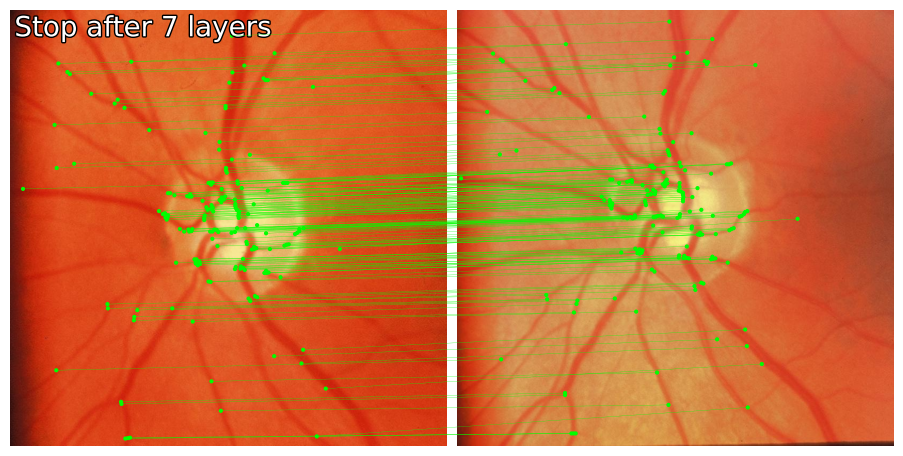

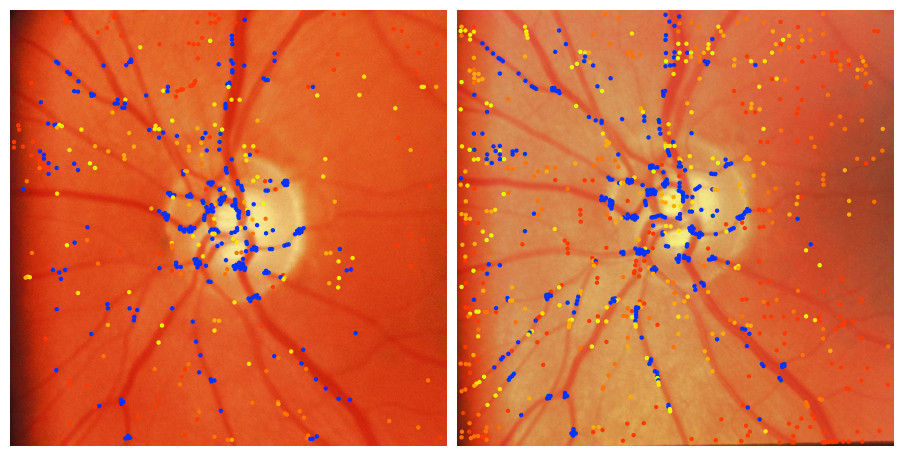

In [5]:
# image0 = load_image(images / "DSC_0411.JPG")
# image1 = load_image(images / "DSC_0410.JPG")

image0 = load_image(images / 'SD1284_1990_04_11_OS.JPG')
image1 = load_image(images / 'SD1284_1999_12_22_OS.JPG')

print(image0.shape, image1.shape)

feats0 = extractor.extract(image0[None, :, :, :].to(device))
feats1 = extractor.extract(image1[None, :, :, :].to(device))

del feats0['keypoint_scores']
del feats0['image_size']
del feats1['keypoint_scores']
del feats1['image_size']
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

In [14]:
matches01.keys()

dict_keys(['matches0', 'matches1', 'matching_scores0', 'matching_scores1', 'stop', 'matches', 'scores', 'prune0', 'prune1'])

In [15]:
feats0['keypoints'].shape, feats1['keypoints'].shape

(torch.Size([513, 2]), torch.Size([896, 2]))

In [19]:
matches01['matches0'].shape, matches01['matches1'].shape, matches01['matching_scores0'].shape, matches01['matching_scores1'].shape

(torch.Size([513]), torch.Size([896]), torch.Size([513]), torch.Size([896]))

In [22]:
matches01['scores']

167

## Difficult example
For pairs with significant viewpoint- and illumination changes, LightGlue can exclude a lot of points early in the matching process (red points), which significantly reduces the inference time.

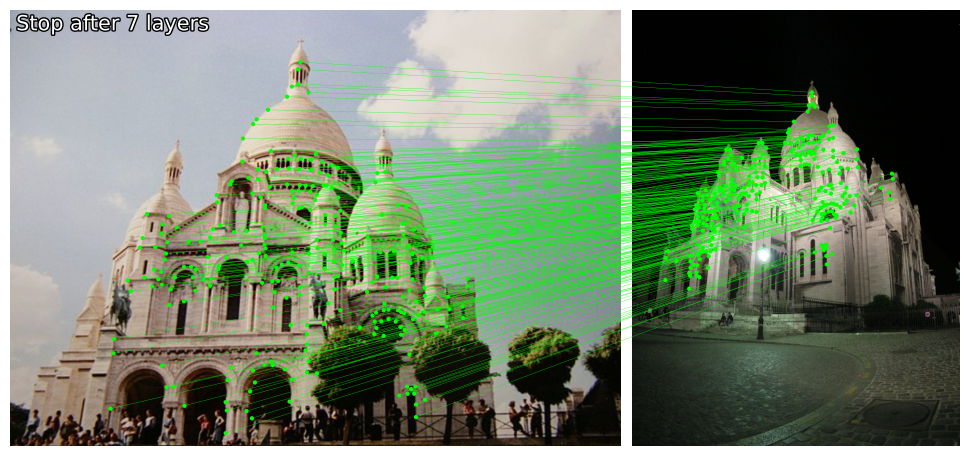

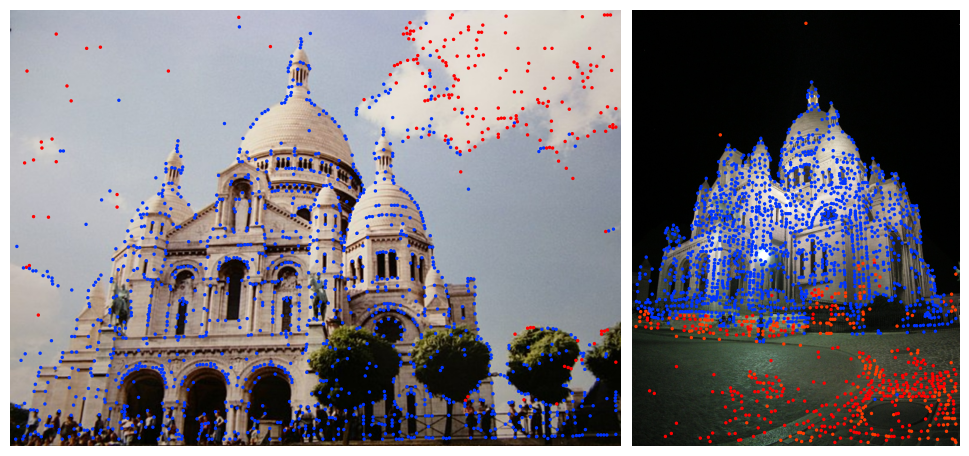

In [4]:
image0 = load_image(images / "sacre_coeur1.jpg")
image1 = load_image(images / "sacre_coeur2.jpg")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers')

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=6)